### Importing Dependencies

In [62]:
# Print all the outputs in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Library for Warning Message
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message=".*no associated frequency information.*")
warnings.filterwarnings("ignore", message=".*Maximum Likelihood optimization failed to converge.*")

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import imghdr

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Remove Dodgy Images

In [4]:
image_dir = 'data'

In [5]:
# Check the sub-folders under mentioned folder
os.listdir(image_dir)

# Check the files under any sub-folders
os.listdir(os.path.join(image_dir, 'happy'))

['happy', '.DS_Store', 'sad']

['images26.jpg',
 'e162ccda8ce0f197f8863f327add9233.jpg',
 '05-12-21-happy-people.jpg',
 'GettyImages-871518740-1024x707.jpg',
 '7-principles-of-successful-and-happy-people.png',
 'how-happy-are-healthy-people.jpg',
 'physed-happiness-facebookJumbo.jpg',
 '170404-happy-workers-feature.jpg',
 'image18.jpeg',
 'MV5BMTM3ODM0NTQ1MF5BMl5BanBnXkFtZTcwMzAxMTM5OA._V1_.jpg',
 'images31.jpg',
 'Happy-people-raise-happy-kids-raise-yourself-first.jpg',
 'habits-that-define-very-happy-people.jpg',
 'goup-happy-people-group-jumping-isolated-white-background-35582232.jpg',
 '1902587.jpg',
 'o-HAPPY-facebook.jpg',
 '07-120104-happy_people_are_not_nice_people.jpg',
 'happy-people-13772392.jpg',
 'images30.jpg',
 'image15.jpeg',
 'young-and-happy-people-vector-15114154.jpg',
 'maxresdefault2.jpg',
 'bigstock-Portrait-Of-Smiling-Employees-272904928-min-scaled.jpg',
 'happy-people-1024x768.jpeg',
 '1902540.jpg',
 'hqdefault.jpg',
 'image19.jpeg',
 'images36.jpg',
 'images22.jpg',
 'tmp_6mv7xy_5d5b15258a50

In [6]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [7]:
for image_class in os.listdir(image_dir):
    # ✅ skip .DS_Store or any hidden files
    if image_class.startswith('.'):
        continue  

    class_path = os.path.join(image_dir, image_class)
    if not os.path.isdir(class_path):
        continue  # ✅ skip non-folders

    for image in os.listdir(class_path):
        if image.startswith('.'):
            continue  # ✅ skip .DS_Store inside class folders too

        image_path = os.path.join(class_path, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print(f'Image not in ext list {image_path}')
                os.remove(image_path)
        except Exception as e:
            print(f'Issue with image {image_path}')
            # os.remove(image_path)  # enable if you want auto-delete

### Load Data

In [8]:
tf.data.Dataset.list_files

<function tensorflow.python.data.ops.dataset_ops.DatasetV2.list_files(file_pattern, shuffle=None, seed=None, name=None) -> 'DatasetV2'>

In [9]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 170 files belonging to 2 classes.


In [10]:
data_iterator = data.as_numpy_iterator()

In [11]:
# Get another batch from the iterator
batch = data_iterator.next()

In [12]:
# Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [13]:
batch[1]

array([1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 0], dtype=int32)

Class 1 = Sad People <br>
Class 0 = Happy People

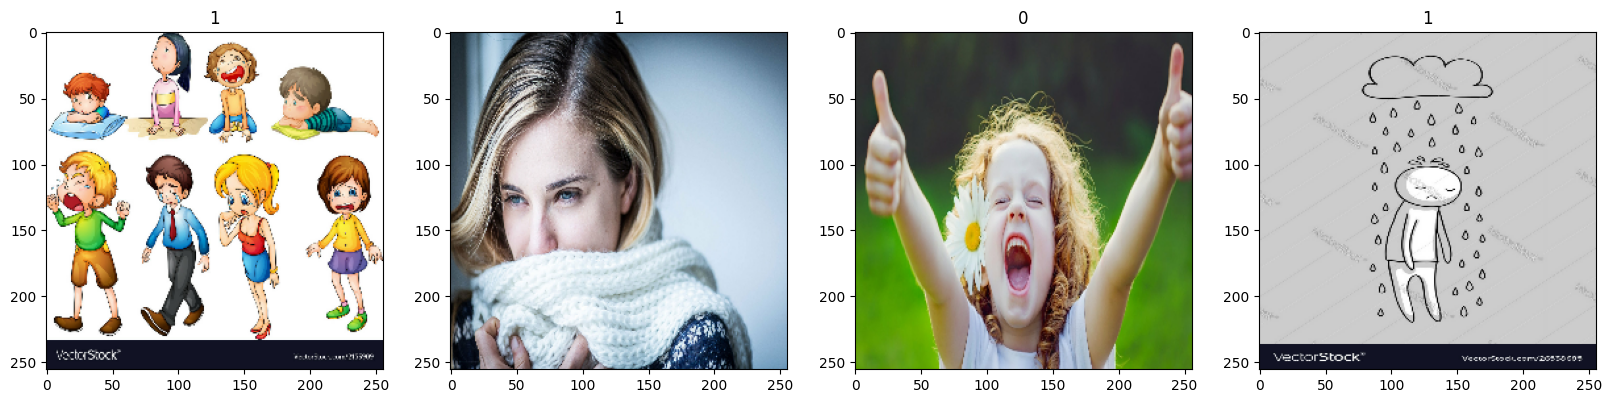

In [14]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### Preprocess Data

**Scale Data**

In [15]:
data = data.map(lambda x,y: (x/255, y))

In [16]:
scaled_iterator = data.as_numpy_iterator()

In [17]:
batch = scaled_iterator.next()

In [18]:
batch[0].min()
batch[0].max()

np.float32(0.0)

np.float32(1.0)

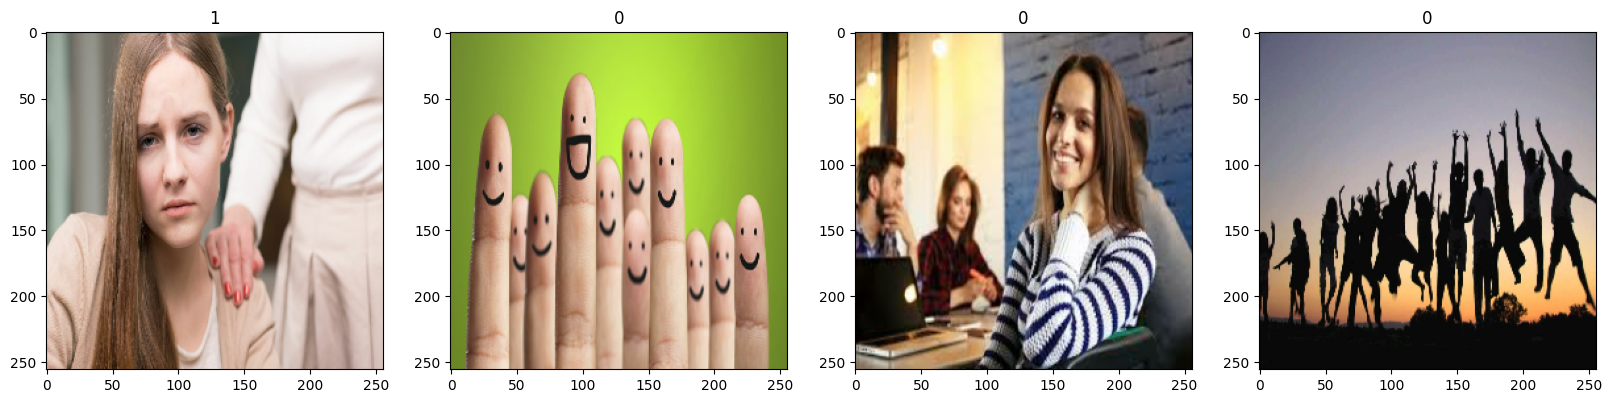

In [19]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

**Split Data**

In [25]:
len(data)

6

In [26]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [28]:
train_size + val_size + test_size

6

In [29]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

### Model Building

**Build Deep Learning Model**

In [32]:
# Initialize the model
model = Sequential()

# Layers
model.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape = (256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [33]:
model.compile('adam', loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [34]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

**Train**

In [35]:
logdir = 'logs'

In [37]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [38]:
hist = model.fit(train, epochs = 20, validation_data = val, callbacks = [tensorboard_callback])

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 437ms/step - accuracy: 0.4297 - loss: 1.2008 - val_accuracy: 0.3750 - val_loss: 0.8614
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 390ms/step - accuracy: 0.4141 - loss: 0.7619 - val_accuracy: 0.5312 - val_loss: 0.6823
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 397ms/step - accuracy: 0.6250 - loss: 0.6374 - val_accuracy: 0.6875 - val_loss: 0.5695
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 410ms/step - accuracy: 0.6719 - loss: 0.5471 - val_accuracy: 0.8125 - val_loss: 0.4862
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 407ms/step - accuracy: 0.8047 - loss: 0.4660 - val_accuracy: 0.6250 - val_loss: 0.5334
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 416ms/step - accuracy: 0.7422 - loss: 0.4580 - val_accuracy: 0.8438 - val_loss: 0.3243
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 402ms/step - accuracy: 0.8438 - loss: 0.3788 - val_accuracy: 0.9062 - val_loss: 0.3344
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 398ms/step - accuracy: 0.8281 - loss: 0.3564 - val_accuracy: 0.9688 - val_loss:

In [40]:
hist.history

{'accuracy': [0.4296875,
  0.4140625,
  0.625,
  0.671875,
  0.8046875,
  0.7421875,
  0.84375,
  0.828125,
  0.921875,
  0.8984375,
  0.9609375,
  0.9609375,
  0.984375,
  0.984375,
  0.9921875,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'loss': [1.2008455991744995,
  0.7618856430053711,
  0.6373720169067383,
  0.5470529794692993,
  0.46601688861846924,
  0.4580303430557251,
  0.3788173794746399,
  0.3564040958881378,
  0.27158138155937195,
  0.24302038550376892,
  0.14957650005817413,
  0.14933913946151733,
  0.08569100499153137,
  0.07705189287662506,
  0.0559842623770237,
  0.036608871072530746,
  0.02340938150882721,
  0.01310599222779274,
  0.0076996819116175175,
  0.005232119932770729],
 'val_accuracy': [0.375,
  0.53125,
  0.6875,
  0.8125,
  0.625,
  0.84375,
  0.90625,
  0.96875,
  1.0,
  1.0,
  1.0,
  1.0,
  0.96875,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'val_loss': [0.8613826036453247,
  0.6823289394378662,
  0.5695117115974426,
  0.4861871898174286,
  0.533379912376

**Plot Performance**

Text(0.5, 0.98, 'Loss')

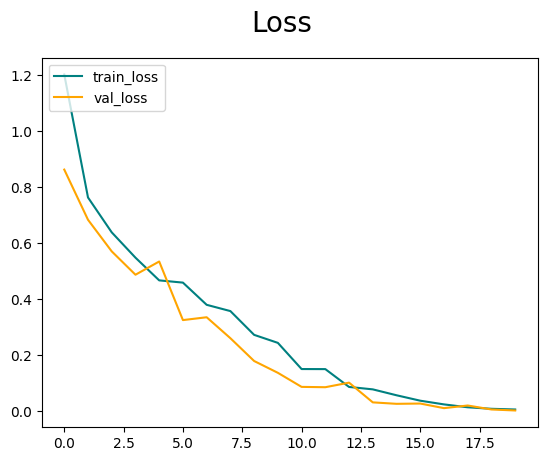

In [42]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = 'train_loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc = "upper left")
plt.show()

Text(0.5, 0.98, 'Accuracy')

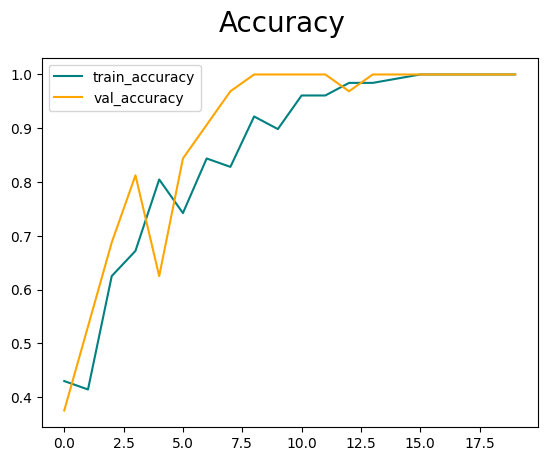

In [43]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label = 'train_accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize = 20)
plt.legend(loc = "upper left")
plt.show()

### Evaluate Performance

**Evaluate**

In [45]:
# Iniatilize
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [47]:
for batch in test.as_numpy_iterator():
    X,y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


2025-09-02 16:14:34.547642: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [51]:
f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuaracy: {acc.result().numpy()}'

'Precision: 1.0, Recall: 1.0, Accuaracy: 1.0'

**Test**

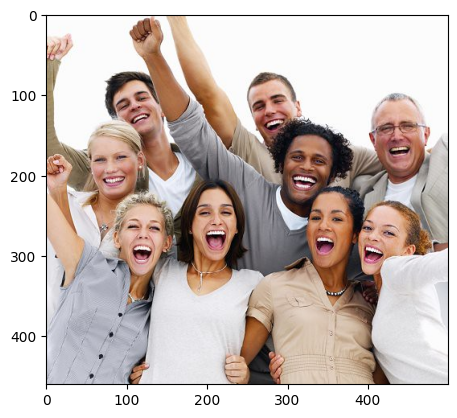

In [53]:
img = cv2.imread('test_img_2.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

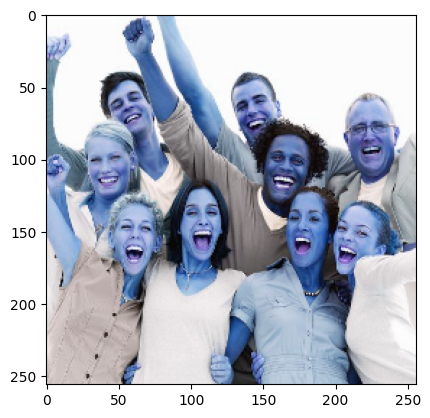

In [54]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [55]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


In [56]:
yhat

array([[0.00019122]], dtype=float32)

In [57]:
if yhat > 0.5:
    print("Predicted Class is Sad")
else:
    print("Predicted Class is Happy")

Predicted Class is Happy


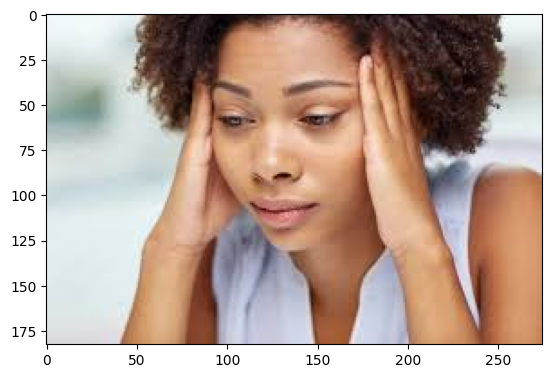

In [58]:
img = cv2.imread('test_img_1.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

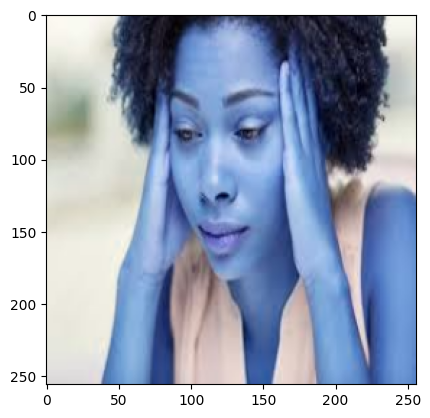

In [59]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [60]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


In [61]:
if yhat > 0.5:
    print("Predicted Class is Sad")
else:
    print("Predicted Class is Happy")

Predicted Class is Sad


### Save the Model

In [63]:
model.save(os.path.join('models', 'Sentiment_Image_Classifier_model.h5'))

In [64]:
new_model = load_model(os.path.join('models', 'Sentiment_Image_Classifier_model.h5'))

In [67]:
yhat_new = new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [68]:
if yhat_new > 0.5:
    print("Predicted Class is Sad")
else:
    print("Predicted Class is Happy")

Predicted Class is Sad
